In [1]:
palette = ["#ca0020", "#bababa", "#e18383", "#b8acad" ]


In [4]:
import pandas as pd
path = ''

In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

model = SentenceTransformer('stsb-roberta-large')

def compute_sim(sentence1, sentence2):
  embedding1 = model.encode(sentence1, convert_to_tensor=True)
  embedding2 = model.encode(sentence2, convert_to_tensor=True)
  # compute similarity scores of two embeddings
  cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)

  return cosine_scores.item()

def compute_embedding(s):
  return model.encode(s, convert_to_tensor=True).numpy()

In [6]:
df_poly_path = path + 'explanations/polyjuice_exp_diverse.xlsx' 
df_mice_path = path + 'explanations/mice_exp_diverse.xlsx' 
groundtruth_col = 'Text'
exp_col = 'Counterfactual'
label_col = 'Original_pred'

In [7]:
df_poly = pd.read_excel(df_poly_path)
print(df_poly.shape)

n = df_poly.shape[0]
df_mice = pd.read_excel(df_mice_path).sample(n)
print(df_mice.shape)

(300, 4)
(300, 4)


In [8]:
df_full = pd.concat([df_poly, df_mice], axis=0)
df_full["Method"] = n*['POLYJUICE'] + n*['MiCE']

In [9]:
df_full = df_full.reset_index()

# Proximity

In [10]:
from sklearn.neighbors import LocalOutlierFactor

def compute_x_xcf(method, label=-1):
  X = []
  X_cf = []
  for i in range(len(df_full[groundtruth_col])):

    if df_full.loc[i, 'Method'] != method:
      continue
    if df_full.loc[i, label_col] !=label and label != -1:
      continue

    x = df_full[groundtruth_col][i]
    x_cf = df_full[exp_col][i]
    e = compute_embedding(x)
    X.append(e)
    if not isinstance(x_cf, str):
      X_cf.append(1024*[0])
    else:
      e = compute_embedding(x_cf)
      X_cf.append(e)

  X = np.array(X)
  X_cf = np.array(X_cf)

  return X, X_cf

def compute_lof(X, X_cf):
  # ----
  lof = []
  for k in range(2, 21):
    clf = LocalOutlierFactor(n_neighbors=k, novelty=True)
    clf.fit(X)

    out = clf.predict(X_cf)
    lof.append(np.sum(out == -1))
  return 100 * np.array(lof) / X.shape[0]


In [11]:
X_poly0, X_cf_poly0 = compute_x_xcf('POLYJUICE', 0)
X_poly1, X_cf_poly1 = compute_x_xcf('POLYJUICE', 1)

X_mice0, X_cf_mice0 = compute_x_xcf('MiCE', 0)
X_mice1, X_cf_mice1 = compute_x_xcf('MiCE', 1)



In [12]:
X_poly_both, X_cf_poly_both = compute_x_xcf('POLYJUICE')

X_mice_both, X_cf_mice_both = compute_x_xcf('MiCE')

In [13]:
lof_poly0 = compute_lof(X_poly0, X_cf_poly0)
lof_poly1 = compute_lof(X_poly1, X_cf_poly1)

In [14]:
lof_mice0 = compute_lof(X_mice0, X_cf_mice0)
lof_mice1 = compute_lof(X_mice1, X_cf_mice1)

In [15]:
lof_poly_both = compute_lof(X_poly_both, X_cf_poly_both)
lof_mice_both = compute_lof(X_mice_both, X_cf_mice_both)

Adv

In [16]:
df_poly_path = path + 'explanations/polyjuice_exp_diverse_adv.xlsx' 
df_mice_path = path + 'explanations/mice_exp_diverse_adv.xlsx' 
groundtruth_col = 'Text'
exp_col = 'Counterfactual'
label_col = 'Original_pred'

In [17]:
df_poly = pd.read_excel(df_poly_path)
print(df_poly.shape)

n = df_poly.shape[0]
df_mice = pd.read_excel(df_mice_path).sample(n)
print(df_mice.shape)

(300, 4)
(300, 4)


In [18]:
df_full = pd.concat([df_poly, df_mice], axis=0)
df_full["Method"] = n*['POLYJUICE'] + n*['MiCE']

In [19]:
df_full = df_full.reset_index()

In [20]:
X_poly_adv, X_cf_poly_adv = compute_x_xcf('POLYJUICE')

X_mice_adv, X_cf_mice_adv = compute_x_xcf('MiCE')

In [21]:
lof_mice_adv = compute_lof(X_mice_adv, X_cf_mice_adv)
lof_poly_adv = compute_lof(X_poly_adv, X_cf_poly_adv)

plot normal

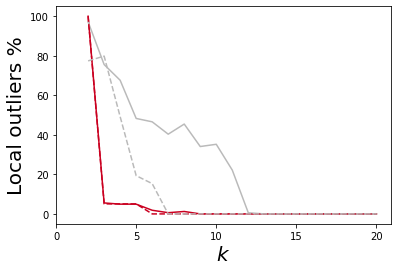

In [50]:
ks = range(2,21)

# lof_poly0 = compute_lof('POLYJUICE', 0)
import matplotlib.pyplot as plt


plt.plot(ks,lof_poly1, '-', label='POLYJUICE +', color=palette[0])
plt.plot(ks,lof_mice1, '-', label='MiCE +', color=palette[1])

plt.plot(ks,lof_poly0, '--', label='POLYJUICE -', color=palette[0])
plt.plot(ks,lof_mice0, '--', label='MiCE -', color=palette[1])
# plt.legend()

plt.xticks(range(0,21,5))
plt.xlabel(r'$k$',fontsize=20)
plt.ylabel('Local outliers %',fontsize=20)
# plt.legend()

plt.savefig(path + 'vis_res/proximity_gran.eps', format='eps', dpi=1200,bbox_inches='tight')

plot adversarial

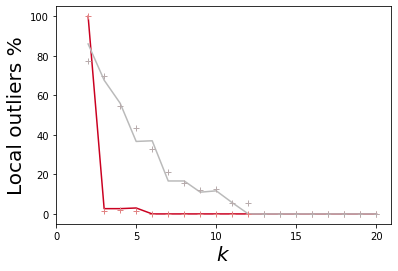

In [51]:
ks = range(2,21)

# lof_poly0 = compute_lof('POLYJUICE', 0)
import matplotlib.pyplot as plt





plt.plot(ks,lof_poly_both, '-', label='POLYJUICE', color=palette[0])
plt.plot(ks,lof_mice_both, '-', label='MiCE', color=palette[1])

plt.plot(ks,lof_poly_adv, '+', label='POLYJUICE adv', color=palette[2])
plt.plot(ks,lof_mice_adv, '+', label='MiCE adv', color=palette[3])


# plt.plot(ks,lof_poly0, '--', label='POLYJUICE -', color=palette[0])
# plt.plot(ks,lof_mice0, '--', label='MiCE -', color=palette[1])
# # plt.legend()

plt.xticks(range(0,21,5))
plt.xlabel(r'$k$',fontsize=20)
plt.ylabel('Local outliers %',fontsize=20)
# plt.legend(fontsize=13)

plt.savefig(path + 'vis_res/proximity_adv.eps', format='eps', dpi=1200,bbox_inches='tight')

# Connectedness

In [29]:
from sklearn.cluster import DBSCAN
epsilons = range(1,27)

def compute_connected(X, X_cf):
  n = X.shape[0]
  X_full = np.zeros((n+n, X.shape[1]))
  X_full[:n, :] = X[:n]
  X_full[n:, :] = X_cf[:n]

  not_conn = []
  for eps in epsilons:
      dbscan = DBSCAN(eps=eps, min_samples=2)
      dbscan.fit(X_full)

      not_connected = 0
      clusters = dbscan.labels_
      n2 = n//2
      for i in range(n2):
          if clusters[i] != clusters[i+n2]:
              not_connected += 1
      not_conn.append(not_connected)
  return 100 - np.array(not_conn) / n * 100

In [30]:
conn_poly0 = compute_connected(X_poly0, X_cf_poly0)
conn_poly1 = compute_connected(X_poly1, X_cf_poly1)

conn_mice0 = compute_connected(X_mice0, X_cf_mice0)
conn_mice1 = compute_connected(X_mice1, X_cf_mice1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


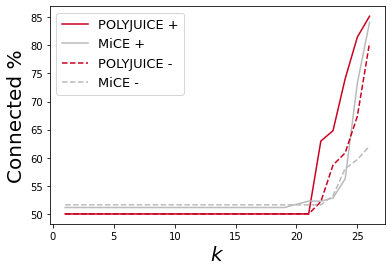

In [31]:

import matplotlib.pyplot as plt

plt.plot(epsilons,conn_poly1, '-', label='POLYJUICE +', color=palette[0])
plt.plot(epsilons,conn_mice1, '-', label='MiCE +', color=palette[1])

plt.plot(epsilons,conn_poly0, '--', label='POLYJUICE -', color=palette[0])
plt.plot(epsilons,conn_mice0, '--', label='MiCE -', color=palette[1])
# plt.legend()

# plt.xticks(eps)
plt.xlabel(r'$k$',fontsize=20)
plt.ylabel('Connected %',fontsize=20)
plt.legend(fontsize=13)

plt.savefig(path + 'vis_res/connectedness_gran.eps', format='eps', dpi=1200,bbox_inches='tight')

In [32]:
conn_poly_both = compute_connected(X_poly_both, X_cf_poly_both)
conn_poly_adv = compute_connected(X_poly_adv, X_cf_poly_adv)

conn_mice_both = compute_connected(X_mice_both, X_cf_mice_both)
conn_mice_adv = compute_connected(X_mice_adv, X_cf_mice_adv)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


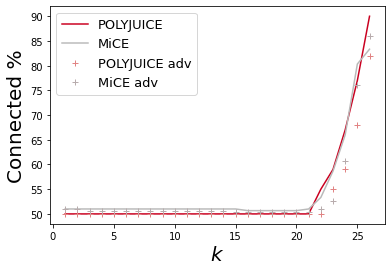

In [34]:
import matplotlib.pyplot as plt

plt.plot(epsilons,conn_poly_both, '-', label='POLYJUICE', color=palette[0])
plt.plot(epsilons,conn_mice_both, '-', label='MiCE', color=palette[1])

plt.plot(epsilons,conn_poly_adv, '+', label='POLYJUICE adv', color=palette[2])
plt.plot(epsilons,conn_mice_adv, '+', label='MiCE adv', color=palette[3])
# plt.legend()

# plt.xticks(eps)
plt.xlabel(r'$k$',fontsize=20)
plt.ylabel('Connected %',fontsize=20)
plt.legend(fontsize=13)

plt.savefig(path + 'vis_res/connectedness_adv.eps', format='eps', dpi=1200,bbox_inches='tight')

## Proximity 2

In [35]:
df1 = pd.read_excel(path + 'results/proxim_dist.xlsx')
df2 = pd.read_excel(path + 'results/proxim_dist2.xlsx')
df3 = pd.read_excel(path + 'results/proxim_dist3.xlsx')


In [36]:
df4 = df1.append([df2,df3])

In [37]:
df4 = df4.drop(columns=['Unnamed: 0'])

In [38]:
df4.head()

sim_x    sim_gt  Label     Method
0  0.879104 -0.102369      1  POLYJUICE
1  0.904906 -0.053929      1  POLYJUICE
2  0.309464  0.057149      1  POLYJUICE
3  0.633325 -0.156892      0  POLYJUICE
4  0.901777 -0.023708      0  POLYJUICE

In [39]:
df4['d_x'] = 1 - df4['sim_x']
df4['d_gt'] = 1 - df4['sim_gt']

In [40]:
df4['P'] = df4['d_x'] / df4['d_gt']

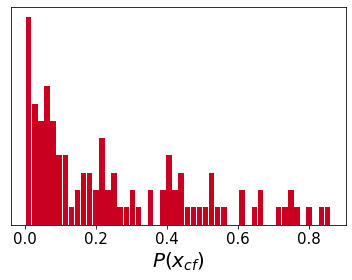

In [53]:
import matplotlib.pyplot as plt

df4[df4['Method'] == 'POLYJUICE']['P'].hist(bins=50, grid=False, figsize=(6,4), color=palette[0], zorder=2, rwidth=0.9) #, color=palette[0]) 86bf91
plt.xlabel(r'$P(x_{cf})$', fontsize=20)
plt.xticks(fontsize= 15)

ax = plt.gca()
ax.axes.yaxis.set_visible(False)

plt.savefig('vis_res/prox_poly.eps', format='eps', dpi=1200,bbox_inches='tight')
# plt.savefig(path + 'vis_res/proximity_gran.eps', format='eps', dpi=1200,bbox_inches='tight')

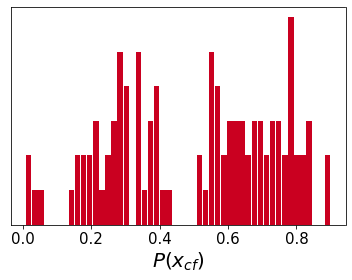

In [55]:
import matplotlib.pyplot as plt

df4[df4['Method'] == 'MiCE']['P'].hist(bins=50, grid=False, figsize=(6,4), color=palette[0], zorder=2, rwidth=0.9) #, color=palette[0]) 86bf91
plt.xlabel(r'$P(x_{cf})$', fontsize=20)
plt.xticks(fontsize= 15)
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

plt.savefig('vis_res/prox_mice.eps', format='eps', dpi=1200,bbox_inches='tight')
# plt.savefig(path + 'vis_res/proximity_gran.eps', format='eps', dpi=1200,bbox_inches='tight')

### Adversarial proximity

In [41]:
df_poly_path = path + 'results/polyjuice_exp_diverse.xlsx' 
df_mice_path = path + 'results/mice_exp_diverse.xlsx' 

df_poly_path_adv = path + 'results/polyjuice_exp_diverse_adv.xlsx' 
df_mice_path_adv = path + 'results/mice_exp_diverse_adv.xlsx' 

In [42]:
df_poly = pd.read_excel(df_poly_path).reset_index()
print(df_poly.shape)

n = df_poly.shape[0]
df_mice = pd.read_excel(df_mice_path).sample(n).reset_index()
print(df_mice.shape)

(300, 5)
(300, 5)


In [43]:
df_poly_adv = pd.read_excel(df_poly_path_adv).reset_index()
print(df_poly_adv.shape)

n = df_poly_adv.shape[0]
df_mice_adv = pd.read_excel(df_mice_path_adv).reset_index()

(300, 5)


In [44]:
df_adv = pd.DataFrame(columns=['Text', 'Text_adv', 'Counterfactual', 'Counterfactual_adv', 'Method', 'Text_proximity', 'Counterfactual_proximity'])

In [ ]:
for i in range(n):
  print(i)
  if i == 60:
    continue
  if isinstance(df_poly.loc[i, 'Text'], float): 
    continue
  if isinstance(df_poly_adv.loc[i, 'Text'], float):
    continue
  if isinstance(df_mice.loc[i, 'Text'], float): 
    continue
  if isinstance(df_mice_adv.loc[i, 'Text'], float):
    continue
  sim_text = compute_sim(df_poly.loc[i, 'Text'], df_poly_adv.loc[i, 'Text'])
  sim_counterfactual = compute_sim(df_poly.loc[i, 'Counterfactual'], df_poly_adv.loc[i, 'Counterfactual'])
  df_adv = df_adv.append({'Text': df_poly.loc[i, 'Text'], 
                          'Counterfactual': df_poly.loc[i, 'Counterfactual'], 
                          'Text_adv': df_poly_adv.loc[i, 'Text'], 
                          'Counterfactual_adv': df_poly_adv.loc[i, 'Counterfactual'], 
                          'Method': 'POLYJUICE',
                          'Text_proximity': sim_text,
                          'Counterfactual_proximity': sim_counterfactual}, ignore_index=True)
  sim_text = compute_sim(df_mice.loc[i, 'Text'], df_mice.loc[i, 'Counterfactual'])
  sim_counterfactual = compute_sim(df_mice.loc[i, 'Counterfactual'], df_mice_adv.loc[i, 'Counterfactual'])
  df_adv = df_adv.append({'Text': df_mice.loc[i, 'Text'], 
                          'Text_adv': df_mice_adv.loc[i, 'Text'], 
                          'Counterfactual': df_mice_adv.loc[i, 'Counterfactual'], 
                          'Counterfactual_adv': df_mice_adv.loc[i, 'Counterfactual'], 
                          'Method': 'MiCE2',
                          'Text_proximity': sim_text,
                          'Counterfactual_proximity': sim_counterfactual}, ignore_index=True)


In [46]:
df_adv[df_adv['Method'] == 'MiCE2']


Text  \
1                                   The food, amazing.   
3    Update.....went back for a second time and it ...   
5    The selection on the menu was great and so wer...   
7                                   So they performed.   
9    In summary, this was a largely disappointing d...   
..                                                 ...   
589  The only thing I did like was the prime rib an...   
591                  The worst was the salmon sashimi.   
593                              We'll never go again.   
595                       The shrimp tender and moist.   
597                      say bye bye to your tip lady!   

                                              Text_adv  \
1        - They never brought a coleslaw we asked for.   
3        - They never brought a coleslaw we asked for.   
5        - They never brought a coleslaw we asked for.   
7        - They never brought a coleslaw we asked for.   
9        - They never brought a coleslaw we asked for.   
..                                                 ...   
589  Also there are combos like a burger, fries, an...   
591  Also there are combos like a burger, fries, an...   
593  Also there are combos like a burger, fries, an...   
595  Also there are combos like a burger, fries, an...   
597  Also there are combos like a burger, fries, an...   

                                        Counterfactual  \
1       - They  actually brought a twist we asked for.   
3           - They  even brought a twist we asked for.   
5     - They never brought a dull minute we asked for.   
7     - They never brought a dull moment we asked for.   
9    - They  totally brought a unique feel we asked...   
..                                                 ...   
589  Also there are  ingredients like a  bacon, fri...   
591  Also there are  staples like a  beer, fries, a...   
593  Also there are  ingredients like a  salad, fri...   
595  Also there are  spoilers like a  salad, fries,...   
597  Also there are  bad ingredients like a  beer, ...   

                                    Counterfactual_adv Method  Text_proximity  \
1       - They  actually brought a twist we asked for.  MiCE2        0.315129   
3           - They  even brought a twist we asked for.  MiCE2        0.759665   
5     - They never brought a dull minute we asked for.  MiCE2        0.416795   
7     - They never brought a dull moment we asked for.  MiCE2        0.551669   
9    - They  totally brought a unique feel we asked...  MiCE2        0.513125   
..                                                 ...    ...             ...   
589  Also there are  ingredients like a  bacon, fri...  MiCE2        0.435320   
591  Also there are  staples like a  beer, fries, a...  MiCE2        0.753440   
593  Also there are  ingredients like a  salad, fri...  MiCE2        0.333334   
595  Also there are  spoilers like a  salad, fries,...  MiCE2        0.350230   
597  Also there are  bad ingredients like a  beer, ...  MiCE2        0.930155   

     Counterfactual_proximity  
1                    0.120198  
3                    0.006348  
5                    0.153070  
7                    0.338244  
9                    0.360074  
..                        ...  
589                  0.346330  
591                  0.314786  
593                  0.096762  
595                  0.310510  
597                  0.012505  

[299 rows x 7 columns]

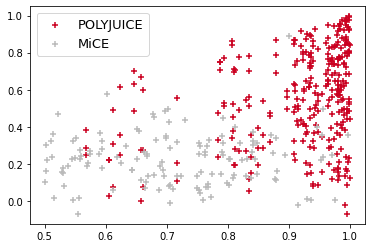

In [56]:
import matplotlib.pyplot as plt

df_mice = df_adv[(df_adv['Method'] == 'MiCE2') & (df_adv['Text_proximity'] >=0.5)]
plt.scatter(df_adv[df_adv['Method'] == 'POLYJUICE']['Text_proximity'], df_adv[df_adv['Method'] == 'POLYJUICE']['Counterfactual_proximity'], color=palette[0], marker='+',  label='POLYJUICE') #, alpha=0.7)
plt.scatter(df_mice['Text_proximity'], df_mice['Counterfactual_proximity'], color=palette[1], marker='+',  label='MiCE') #, alpha=0.7)

plt.legend(fontsize=13)
# df_adv.plot.scatter(x='Text_proximity', y='Counterfactual_proximity', hue='Method')

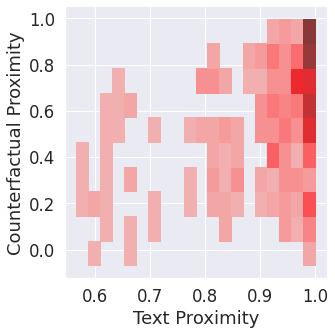

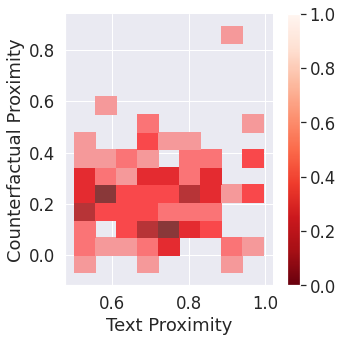

In [79]:
import seaborn as sns2
sns2.set_style("whitegrid")
sns2.set(font_scale=1.5)

sns2.set_palette("Reds_r")
sm = plt.cm.ScalarMappable(cmap="Reds_r")


p1 = sns2.displot(data=df_adv[df_adv['Method'] == 'POLYJUICE'], x="Text_proximity", y="Counterfactual_proximity")
p2 = sns2.displot(data=df_mice, x="Text_proximity", y="Counterfactual_proximity")

# p1.set_ylabel('Counterfactual Proximity',size=6)

p1.set(xlabel='Text Proximity', ylabel='Counterfactual Proximity')
p2.set(xlabel='Text Proximity', ylabel='Counterfactual Proximity')


p2.figure.colorbar(sm)

p1.figure.savefig('/content/drive/MyDrive/PhD/19-contrastive NLP/vis_res/adv_prox_poly.eps', format='eps', dpi=1200,bbox_inches='tight')
p2.figure.savefig('/content/drive/MyDrive/PhD/19-contrastive NLP/vis_res/adv_proxy_mice.eps', format='eps', dpi=1200,bbox_inches='tight')